In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = f"{7}"

In [3]:
import torch
import torch.nn as nn

import numpy as np
from torch.utils.data import Dataset, DataLoader

import torch.optim as optim

from torchvision import transforms
import matplotlib.pyplot as plt

/home/dg321/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data

### Load flow data

In [5]:
Latent_data_Velocity = np.load('/home/dg321/gitTest/PRI/irp/FlowPassBuilding/Flow_Data/Latent_data_Velocity_256_256_326464.npy')
Latent_data_Velocity = Latent_data_Velocity.reshape(501, 32, 64, 64)
print(Latent_data_Velocity.shape)

(501, 32, 64, 64)


In [6]:
# training set
Latent_data_Velocity_training = Latent_data_Velocity[:450,:,:,:]

In [7]:
# test set
Latent_data_Velocity_test = Latent_data_Velocity[450:,:,:,:]

In [8]:
# # save training and test sets
# np.save('/home/dg321/gitTest/PRI/irp/Flow_Data/Latent_data_VelocityXs_training.npy', Latent_data_Velocity_training)
# np.save('/home/dg321/gitTest/PRI/irp/Flow_Data/Latent_data_VelocityXs_test.npy', Latent_data_Velocity_test)

### Load building data

In [9]:
Latent_data_Building = np.load("/home/dg321/gitTest/PRI/irp/FlowPassBuilding/Flow_Data/Latent_data_Building_256_256_166464.npy")
Latent_data_Building = Latent_data_Building.reshape(1, 16, 64, 64)
print(Latent_data_Building.shape)

(1, 16, 64, 64)


(1, 16, 64, 64)
torch.Size([16, 64, 64])
(1, 256, 256)


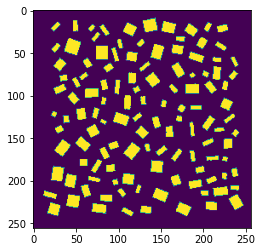

In [10]:
# Load the saved cae for building

## for building
class Autoencoder_building(nn.Module):
    def __init__(self):
        super(Autoencoder_building, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=2, stride=2, padding=0),  # Change kernel_size and stride to 2
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=2, stride=2, padding=0),  # Change kernel_size and stride to 2
            nn.ReLU()
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 32, kernel_size=2, stride=2, padding=0),  # Change kernel_size and stride to 2
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2, padding=0),   # Change kernel_size and stride to 2
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

autoencoder_building = Autoencoder_building()  # Assuming you have the ConvAutoencoder class defined
autoencoder_building.load_state_dict(torch.load('/home/dg321/gitTest/PRI/irp/FlowPassBuilding/MainCodes/models/autoencoder_Flow_Building_256_256_2000epochs.pth'))

autoencoder_building.eval()  # Set the autoencoder to evaluation mode

print(Latent_data_Building.shape)
input_data = torch.from_numpy(Latent_data_Building[0]).float()
print(input_data.shape)
res = autoencoder_building.decoder(input_data)
output_data = res.detach().numpy()
print(output_data.shape)

plt.figure()
plt.imshow(output_data[0])

In [11]:
# Set a seed for reproducibility
np.random.seed(42)

# Get the indices of 0 values
sensors_indices = np.argwhere(output_data <= 0.00001)

# Number of points to randomly select
num_points_to_select = 10

# Randomly select indices
selected_indices = sensors_indices[np.random.choice(len(sensors_indices), size=num_points_to_select, replace=False)]

# Print the selected indices
print("Selected Indices:")
print(selected_indices)

Selected Indices:
[[  0  37  66]
 [  0 102  27]
 [  0  87 148]
 [  0  67 245]
 [  0 105 156]
 [  0 195 133]
 [  0  78 130]
 [  0 181 199]
 [  0 177  70]
 [  0 166 103]]


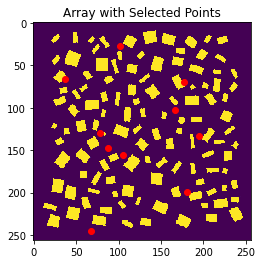

In [12]:
# Visualize the array and selected points
plt.imshow(output_data[0], interpolation='none')

# Plot selected points as red dots
plt.scatter(selected_indices[:, 1], selected_indices[:, 2], color='red', marker='o')

plt.title('Array with Selected Points')
plt.show()

In [13]:
sensor_names = ["S1", "S2", "S3", "S4", "S5", "S6", "S7", "S8", "S9", "S10"]

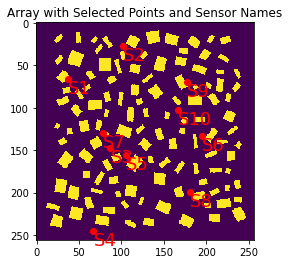

In [14]:
import matplotlib.pyplot as plt

sensor_names = ["S1", "S2", "S3", "S4", "S5", "S6", "S7", "S8", "S9", "S10"]

# Visualize the array and selected points
plt.imshow(output_data[0], interpolation='none')

# Plot selected points as red dots
plt.scatter(selected_indices[:, 1], selected_indices[:, 2], color='red', marker='o')

# Annotate each point with the corresponding sensor name
for i, name in enumerate(sensor_names):
    plt.text(selected_indices[i, 1], selected_indices[i, 2], name, color='red', fontsize=18, ha='left', va='top')

plt.title('Array with Selected Points and Sensor Names')
plt.show()


#### Create sensors

In [15]:
sensors_x = selected_indices[:, 1]
sensors_y = selected_indices[:, 2]

### Combine Velocity and Building

In [16]:
n_sampels = 80
t_gaps_sampels = 5
dt = 5
ntimes = 3

batch_size = 1  # Choose your desired batch size


samples_training = []
samples_training_X = []
samples_training_Y = []

for i in range(1, n_sampels+1):
    ii = 1 + i*t_gaps_sampels
    # s = np.concatenate([Latent_data_VelocityXs_training[ss] for ss in range(ii,ii + dt*ntimes, dt )], axis = 0)
    s = np.stack([Latent_data_Velocity_training[ss] for ss in range(ii,ii + dt*ntimes, dt )])
    s_building = Latent_data_Building
    # ss_0 = np.concatenate((s[0].reshape(1, 32, 64, 64), s_building), axis=1)   # X
    ss_0 = np.concatenate((s[0].reshape(1, 32, 64, 64), s[1].reshape(1, 32, 64, 64), s_building), axis=1)   # X

    ss_1 = s[2].reshape(1, 32, 64, 64)   # Y
    # ss_1 = ss_0


    ss = (ss_0, ss_1)
    print(ss[0].shape)
    print(ss[1].shape)
    samples_training.append(ss)
    samples_training_X.append(ss_0)
    samples_training_Y.append(ss_1)

(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 

In [17]:
samples_training_X_stacked = (np.stack(samples_training_X)).reshape(n_sampels, ss_0.shape[1], 64, 64)
print(samples_training_X_stacked.shape)

(80, 80, 64, 64)


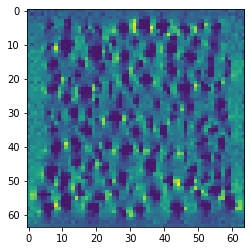

In [18]:
plt.imshow(samples_training_X_stacked[0][0])

In [19]:
samples_training_Y_stacked = (np.stack(samples_training_Y)).reshape(n_sampels, ss_1.shape[1], 64, 64)
print(samples_training_Y_stacked.shape)

(80, 32, 64, 64)


(array([242094.,  73566.,   6104.,   1856.,    785.,    908.,    769.,
           641.,    553.,    404.]),
 array([ 0.       ,  2.4357257,  4.8714514,  7.3071775,  9.742903 ,
        12.178629 , 14.614355 , 17.050081 , 19.485806 , 21.921532 ,
        24.357258 ], dtype=float32),
 <BarContainer object of 10 artists>)

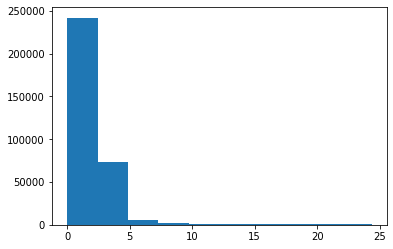

In [20]:
plt.hist(samples_training_X_stacked[0].flatten())

(array([26042., 29981.,  3704.,  1751.,   783.,   908.,   769.,   641.,
          553.,   404.]),
 array([ 0.       ,  2.4357257,  4.8714514,  7.3071775,  9.742903 ,
        12.178629 , 14.614355 , 17.050081 , 19.485806 , 21.921532 ,
        24.357258 ], dtype=float32),
 <BarContainer object of 10 artists>)

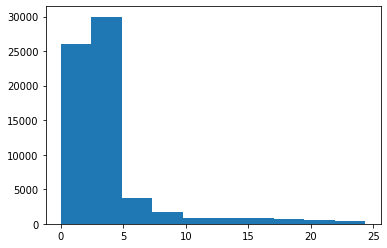

In [21]:
plt.hist(Latent_data_Building.flatten())

## Create data loader

In [17]:
data = samples_training
print(len(data))

80


In [18]:
import torch
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, data_x, data_y):
        self.data_x = data_x
        self.data_y = data_y

    def __len__(self):
        return len(self.data_x)

    def __getitem__(self, idx):
        sample = {'input': self.data_x[idx], 'target': self.data_y[idx]}
        return sample

# Create an instance of your custom dataset
my_dataset = MyDataset(samples_training_X_stacked, samples_training_Y_stacked)

# Create a DataLoader for batching and shuffling the data
shuffle = False  # Set to True if you want to shuffle the data during training

data_loader = DataLoader(my_dataset, batch_size=batch_size, shuffle=shuffle)


## Define the model

In [23]:
# Encoder and Decoder (same as before)
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(ss_0.shape[1], 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            # Add more convolutional layers as needed
        )

    def forward(self, x):
        return self.encoder(x)

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, ss_1.shape[1], kernel_size=5, stride=1, padding=2),
            nn.Identity(),
            # Add more convolutional layers as needed
        )

    def forward(self, x):
        return self.decoder(x)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 1, kernel_size=5, stride=1, padding=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.discriminator(x)

# Adversarial Autoencoder (AAE)
class AdversarialAutoencoder(nn.Module):
    def __init__(self, encoder, decoder, discriminator):
        super(AdversarialAutoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.discriminator = discriminator

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        discriminated = self.discriminator(encoded)
        return decoded, discriminated


## Train model

In [62]:
# Instantiate components and move to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = Encoder().to(device)
decoder = Decoder().to(device)
discriminator = Discriminator().to(device)
aae_model = AdversarialAutoencoder(encoder, decoder, discriminator).to(device)

# Loss functions
reconstruction_loss_fn = nn.MSELoss()
adversarial_loss_fn = nn.BCELoss()

# Optimizers
lr_ae = 0.001
lr_d = 0.001

optimizer_ae = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr_ae)
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr_d)

Epoch [1/300], AE Loss: 1.0438, D Loss: 0.7144
Epoch [2/300], AE Loss: 0.1769, D Loss: 0.1316
Epoch [3/300], AE Loss: 0.1413, D Loss: 0.0578
Epoch [4/300], AE Loss: 0.1247, D Loss: 0.0327
Epoch [5/300], AE Loss: 0.1135, D Loss: 0.0218
Epoch [6/300], AE Loss: 0.1060, D Loss: 0.0169
Epoch [7/300], AE Loss: 0.0997, D Loss: 0.0131
Epoch [8/300], AE Loss: 0.0946, D Loss: 0.0121
Epoch [9/300], AE Loss: 0.0903, D Loss: 0.0094
Epoch [10/300], AE Loss: 0.0865, D Loss: 0.0074
Epoch [11/300], AE Loss: 0.0831, D Loss: 0.0063
Epoch [12/300], AE Loss: 0.0802, D Loss: 0.0056
Epoch [13/300], AE Loss: 0.0773, D Loss: 0.0050
Epoch [14/300], AE Loss: 0.0752, D Loss: 0.0046
Epoch [15/300], AE Loss: 0.0735, D Loss: 0.0045
Epoch [16/300], AE Loss: 0.0719, D Loss: 0.0043
Epoch [17/300], AE Loss: 0.0705, D Loss: 0.0042
Epoch [18/300], AE Loss: 0.0694, D Loss: 0.0039
Epoch [19/300], AE Loss: 0.0682, D Loss: 0.0044
Epoch [20/300], AE Loss: 0.0672, D Loss: 0.0057
Epoch [21/300], AE Loss: 0.0658, D Loss: 0.0048
E

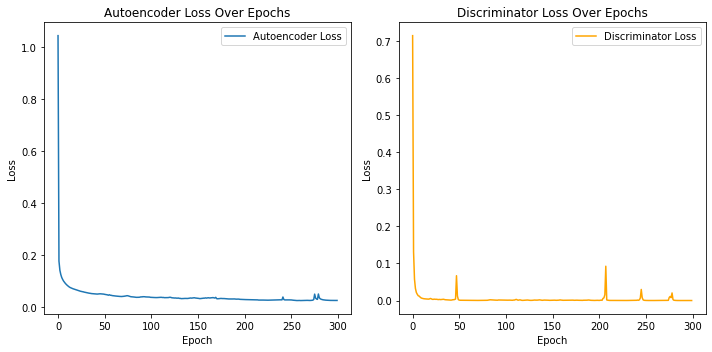

Training finished.


In [63]:
num_epochs = 300

# Lists to store losses for plotting
all_losses_ae = []
all_losses_d = []

# Training loop
for epoch in range(num_epochs):
    epoch_losses_ae = []
    epoch_losses_d = []

    for batch in data_loader:
        inputs, targets = batch['input'].to(device), batch['target'].to(device)

        # Train autoencoder
        optimizer_ae.zero_grad()
        decoded, discriminated = aae_model(inputs)
        loss_ae = reconstruction_loss_fn(decoded, targets)
        loss_ae.backward()
        optimizer_ae.step()
        epoch_losses_ae.append(loss_ae.item())

        # Train discriminator
        optimizer_d.zero_grad()
        with torch.no_grad():
            encoded_fake = encoder(inputs).detach()
            encoded_true = torch.randn_like(encoded_fake).to(device)
        fake_output = discriminator(encoded_fake)
        true_output = discriminator(encoded_true)
        loss_d = adversarial_loss_fn(fake_output, torch.zeros_like(fake_output).to(device)) + \
                 adversarial_loss_fn(true_output, torch.ones_like(true_output).to(device))
        loss_d.backward()
        optimizer_d.step()
        epoch_losses_d.append(loss_d.item())

    # Average losses over the epoch
    avg_loss_ae = sum(epoch_losses_ae) / len(epoch_losses_ae)
    avg_loss_d = sum(epoch_losses_d) / len(epoch_losses_d)

    # Print the average loss at the end of each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], AE Loss: {avg_loss_ae:.4f}, D Loss: {avg_loss_d:.4f}')

    # Record the losses for plotting
    all_losses_ae.append(avg_loss_ae)
    all_losses_d.append(avg_loss_d)

# Plot the losses separately
plt.figure(figsize=(10, 5))

# Autoencoder Loss Plot
plt.subplot(1, 2, 1)
plt.plot(all_losses_ae, label='Autoencoder Loss')
plt.title('Autoencoder Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Discriminator Loss Plot
plt.subplot(1, 2, 2)
plt.plot(all_losses_d, label='Discriminator Loss', color='orange')
plt.title('Discriminator Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

print("Training finished.")

In [64]:
aae_model.cpu()

AdversarialAutoencoder(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(80, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU()
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): Identity()
    )
  )
  (discriminator): Discriminator(
    (discriminator): Sequential(
      (0): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): BatchNorm2d(64, eps=1e-0

### Save trained model

In [126]:
torch.save(aae_model.state_dict(), '/home/dg321/gitTest/PRI/irp/FlowPassBuilding/Flow_Data/PredictionModel/autoencoder_Flow_PredictionLatent_{}epochs_Updated_AAE80Samples.pth'.format(num_epochs))  ### PredictionMulti

## Load saved model - AAE

In [75]:
num_epochs = 300

# Load the saved autoencoder
# Instantiate components
encoder = Encoder()
decoder = Decoder()
discriminator = Discriminator()
aae_model = AdversarialAutoencoder(encoder, decoder, discriminator)

# aae_model.load_state_dict(torch.load('/home/dg321/gitTest/PRI/irp/FlowPassBuilding/Flow_Data/PredictionModel/autoencoder_Flow_PredictionLatent_1000epochs_AAE80Samples.pth'))

# aae_model.load_state_dict(torch.load('/home/dg321/gitTest/PRI/irp/FlowPassBuilding/Flow_Data/PredictionModel/autoencoder_Flow_PredictionLatent_{}epochs_Updated_AAE80Samples.pth'.format(num_epochs)))
aae_model.eval()  # Set the autoencoder to evaluation mode
autoencoderP = aae_model

### Load PcNN as comparison

In [80]:
### improved model
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(ss_0.shape[1], 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            # Add more convolutional layers as needed
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, ss_1.shape[1], kernel_size=5, stride=1, padding=2),
            nn.Identity(),
            # Add more convolutional layers as needed
        )

    def forward(self, x):
        x_encoder = self.encoder(x)
        x_decoder = self.decoder(x_encoder)
        return x_decoder

# Instantiate the improved model
model = MyModel()
model = model.float()

# Load the saved autoencoder
autoencoderP = MyModel()  # Assuming you have the ConvAutoencoder class defined
# autoencoder.load_state_dict(torch.load('/home/dg321/gitTest/PRI/irp/interpolation_code_example_2D/models/Velocity256_Compression_1000epochs_64batchsize_lr0.003_updatedLoss.pth'))
# autoencoder.load_state_dict(torch.load('/home/dg321/gitTest/PRI/irp/interpolation_code_example_2D/models/Velocity256_Compression_1000epochs_32batchsize_lr0.003_updatedLoss.pth'))
# autoencoder.load_state_dict(torch.load('/home/dg321/gitTest/PRI/irp/interpolation_code_example_2D/models/Velocity256_Compression_1000epochs_64batchsize_lr0.003_updatedLoss.pth'))
autoencoderP.load_state_dict(torch.load('/home/dg321/gitTest/PRI/irp/FlowPassBuilding/Flow_Data/PredictionModel/autoencoder_Flow_PredictionLatent_2000epochs_AE80Samples.pth'))

autoencoderP.eval()  # Set the autoencoder to evaluation mode

MyModel(
  (encoder): Sequential(
    (0): Conv2d(80, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Sequential(
    (0): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): Identity()
  )
)

## Generate result plots

In [27]:
def mse_loss(image1, image2):

    mse = np.mean((image1 - image2)**2)
    return mse


### Load CAE model

In [28]:
## for velocity
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(2, 32, kernel_size=2, stride=2, padding=0),  # Change kernel_size and stride to 2
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=2, stride=2, padding=0),  # Change kernel_size and stride to 2
            nn.ReLU()
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2, padding=0),  # Change kernel_size and stride to 2
            nn.ReLU(),
            nn.ConvTranspose2d(32, 2, kernel_size=2, stride=2, padding=0),   # Change kernel_size and stride to 2
            nn.Identity()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Load the saved autoencoder
autoencoder = Autoencoder()  # Assuming you have the ConvAutoencoder class defined
autoencoder.load_state_dict(torch.load('/home/dg321/gitTest/PRI/irp/FlowPassBuilding/MainCodes/models/Velocity256_Compression_1500epochs_32batchsize_lr0.001_326464.pth'))

autoencoder.eval()  # Set the autoencoder to evaluation mode

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(2, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(2, 2), stride=(2, 2))
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(32, 2, kernel_size=(2, 2), stride=(2, 2))
    (3): Identity()
  )
)

In [29]:
sample = Latent_data_Velocity[281]
print(sample.shape)

(32, 64, 64)


In [30]:
input_data = torch.from_numpy(sample[:32,:,:]).unsqueeze(0).float()
print(input_data.shape)
res = autoencoder.decoder(input_data)
output_data = res.detach().numpy()
print(output_data.shape)

torch.Size([1, 32, 64, 64])
(1, 2, 256, 256)


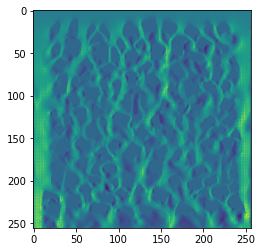

In [31]:
plt.figure()
plt.imshow(output_data[0,0])

### Predict for one sample

In [32]:
sampleX = torch.from_numpy((samples_training_X_stacked[0]).reshape(1,ss_0.shape[1],64,64)).float()
print(sampleX.shape)

torch.Size([1, 80, 64, 64])


In [33]:
with torch.no_grad():
    aae_model.eval()  # Set the model to evaluation mode
    prediction = aae_model(sampleX)

(1, 32, 64, 64)


(array([1.5870e+03, 5.6334e+04, 4.9769e+04, 1.8017e+04, 3.7100e+03,
        1.1700e+03, 3.6700e+02, 8.6000e+01, 2.3000e+01, 9.0000e+00]),
 array([-0.9707172 ,  0.16676438,  1.304246  ,  2.4417276 ,  3.579209  ,
         4.7166905 ,  5.854172  ,  6.991654  ,  8.129135  ,  9.266617  ,
        10.4040985 ], dtype=float32),
 <BarContainer object of 10 artists>)

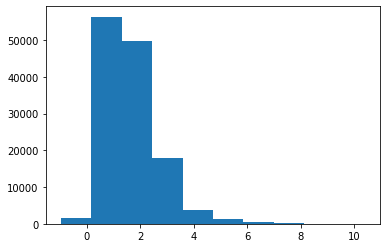

In [34]:
prediction = prediction[0].cpu().detach().numpy()
print(prediction.shape)
plt.hist(prediction.flatten())

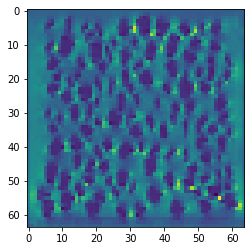

In [35]:
plt.imshow(prediction[0][4])

(1, 32, 64, 64)
(1, 2, 256, 256)


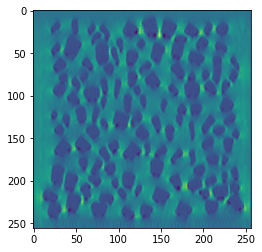

In [36]:
# input_data = torch.from_numpy(prediction).unsqueeze(0).float()
input_data = prediction[:1, :, :, :]
print(input_data.shape)
res = autoencoder.decoder(torch.from_numpy(input_data))
output_data = res.detach().numpy()
print(output_data.shape)
plt.figure()
plt.imshow(output_data[0,0])

### Predict for training

In [82]:
# Plot the results together

def plot_results_together(id_sample):
    velocity_field = 0

    sampleX = samples_training_X_stacked[id_sample]
    sampleY = samples_training_Y_stacked[id_sample]


    X1_decoded = autoencoder.decoder(torch.from_numpy(sampleX[:32,:,:]).unsqueeze(0).float())
    X1_decoded = X1_decoded.detach().numpy()

    X2_decoded = autoencoder.decoder(torch.from_numpy(sampleX[32:32+32,:,:]).unsqueeze(0).float())
    X2_decoded = X2_decoded.detach().numpy()

    Y_decoded = autoencoder.decoder(torch.from_numpy(sampleY[:,:,:]).unsqueeze(0).float())
    Y_decoded = Y_decoded.detach().numpy()

    prediction = aae_model(torch.from_numpy(sampleX).unsqueeze(0).float())[0]

    print(prediction.shape)

    prediction_decoded = autoencoder.decoder(prediction[:1, :, :, :])
    prediction_decoded = prediction_decoded.detach().numpy()


    loss = mse_loss(Y_decoded.flatten(), prediction_decoded.flatten())
    print("prediction error:", loss)


    # plt.figure()

    # f, axarr = plt.subplots(2,4, figsize=(18, 9))

    # # plot latent space
    # sub1 = axarr[0][0].imshow(sampleX[0], interpolation='none')
    # axarr[0][0].title.set_text('Latent X1')

    # sub2 = axarr[0][1].imshow(sampleX[32], interpolation='none')
    # axarr[0][1].title.set_text('Latent X2')

    # sub3 = axarr[0][2].imshow(sampleY[0], interpolation='none')
    # axarr[0][2].title.set_text('Latent Y_Target')

    # sub4 = axarr[0][3].imshow((prediction.detach().numpy())[0][0], interpolation='none')
    # axarr[0][3].title.set_text('Latent Y_Prediction')

    # # plot decoded space
    # sub11 = axarr[1][0].imshow(X1_decoded[0][velocity_field], interpolation='none')
    # axarr[1][0].title.set_text('X1')

    # sub12 = axarr[1][1].imshow(X2_decoded[0][velocity_field], interpolation='none')
    # axarr[1][1].title.set_text('X2')

    # sub13 = axarr[1][2].imshow(Y_decoded[0][velocity_field], interpolation='none')
    # axarr[1][2].title.set_text('Y_Target')

    # sub14 = axarr[1][3].imshow(prediction_decoded[0][velocity_field], interpolation='none')
    # axarr[1][3].title.set_text('Y_Prediction')

In [83]:
for i in range(1,18,1):
    plot_results_together(i)

torch.Size([1, 32, 64, 64])
prediction error: 0.02058327
torch.Size([1, 32, 64, 64])
prediction error: 0.020070711
torch.Size([1, 32, 64, 64])
prediction error: 0.020544365
torch.Size([1, 32, 64, 64])
prediction error: 0.02184441
torch.Size([1, 32, 64, 64])
prediction error: 0.022667656
torch.Size([1, 32, 64, 64])
prediction error: 0.02353146
torch.Size([1, 32, 64, 64])
prediction error: 0.02403163
torch.Size([1, 32, 64, 64])
prediction error: 0.025215345
torch.Size([1, 32, 64, 64])
prediction error: 0.025758598
torch.Size([1, 32, 64, 64])
prediction error: 0.026848163
torch.Size([1, 32, 64, 64])
prediction error: 0.027820472
torch.Size([1, 32, 64, 64])
prediction error: 0.02960806
torch.Size([1, 32, 64, 64])
prediction error: 0.031423915
torch.Size([1, 32, 64, 64])
prediction error: 0.031915523
torch.Size([1, 32, 64, 64])
prediction error: 0.03247411
torch.Size([1, 32, 64, 64])
prediction error: 0.03377065
torch.Size([1, 32, 64, 64])
prediction error: 0.03378295


### Predict for test

In [84]:
# test set
# Latent_data_Velocity_test = Latent_data_Velocity[timesteps - 50:,:,:,:]
Latent_data_Velocity_test = Latent_data_Velocity[450:,:,:,:]
print(Latent_data_Velocity_test.shape)

(51, 32, 64, 64)


In [85]:
xysize_latent = 64

In [86]:
n_sampels = 30
t_gaps_sampels = 1
dt = 5
ntimes = 3

batch_size = 1  # Choose your desired batch size

samples_test = []
samples_test_X = []
samples_test_Y = []

for i in range(1, n_sampels+1):
    ii = 1 + i*t_gaps_sampels
    # s = np.concatenate([Latent_data_VelocityXs_test[ss] for ss in range(ii,ii + dt*ntimes, dt )], axis = 0)
    s = np.stack([Latent_data_Velocity_test[ss] for ss in range(ii,ii + dt*ntimes, dt )])
    s_building = Latent_data_Building
    # ss_0 = np.concatenate((s[0].reshape(1, 32, xysize_latent, xysize_latent), s_building), axis=1)   # X
    ss_0 = np.concatenate((s[0].reshape(1, 32, xysize_latent, xysize_latent), s[1].reshape(1, 32, xysize_latent, xysize_latent), s_building), axis=1)   # X

    ss_1 = s[2].reshape(1, 32, xysize_latent, xysize_latent)   # Y
    # ss_1 = ss_0


    ss = (ss_0, ss_1)
    # print(ss[0].shape)
    # print(ss[1].shape)
    samples_test.append(ss)
    samples_test_X.append(ss_0)
    samples_test_Y.append(ss_1)


samples_test_X_stacked = (np.stack(samples_test_X)).reshape(n_sampels, ss_0.shape[1], xysize_latent, xysize_latent)
# print(samples_test_X_stacked.shape)

samples_test_Y_stacked = (np.stack(samples_test_Y)).reshape(n_sampels, ss_1.shape[1], xysize_latent, xysize_latent)
# print(samples_test_Y_stacked.shape)

In [87]:
# Plot the results together

def plot_results_together(id_sample, velocity_field):
    velocity_field = velocity_field

    sampleX = samples_test_X_stacked[id_sample]
    sampleY = samples_test_Y_stacked[id_sample]


    X1_decoded = autoencoder.decoder(torch.from_numpy(sampleX[:32,:,:]).unsqueeze(0).float())
    X1_decoded = X1_decoded.detach().numpy()

    X2_decoded = autoencoder.decoder(torch.from_numpy(sampleX[32:32+32,:,:]).unsqueeze(0).float())
    X2_decoded = X2_decoded.detach().numpy()

    Y_decoded = autoencoder.decoder(torch.from_numpy(sampleY[:,:,:]).unsqueeze(0).float())
    Y_decoded = Y_decoded.detach().numpy()

    # change here to switch models
    # prediction = autoencoderP(torch.from_numpy(sampleX).unsqueeze(0).float())
    prediction = autoencoderP(torch.from_numpy(sampleX).unsqueeze(0).float())
    if isinstance(prediction, tuple):
        prediction = prediction[0]

    prediction_decoded = autoencoder.decoder(prediction[:1, :, :, :])
    prediction_decoded = prediction_decoded.detach().numpy()


    loss = mse_loss(Y_decoded.flatten(), prediction_decoded.flatten())
    print("prediction error:", loss)


    # plt.figure()

    # f, axarr = plt.subplots(2,4, figsize=(18, 9))

    # # plot latent space
    # sub1 = axarr[0][0].imshow(sampleX[0], interpolation='none')
    # axarr[0][0].title.set_text('Latent X1')

    # sub2 = axarr[0][1].imshow(sampleX[32], interpolation='none')
    # axarr[0][1].title.set_text('Latent X2')

    # sub3 = axarr[0][2].imshow(sampleY[0], interpolation='none')
    # axarr[0][2].title.set_text('Latent Y_Target')

    # sub4 = axarr[0][3].imshow((prediction.detach().numpy())[0][0], interpolation='none')
    # axarr[0][3].title.set_text('Latent Y_Prediction')

    # # plot decoded space
    # sub11 = axarr[1][0].imshow(X1_decoded[0][velocity_field], interpolation='none')
    # axarr[1][0].title.set_text('X1')

    # sub12 = axarr[1][1].imshow(X2_decoded[0][velocity_field], interpolation='none')
    # axarr[1][1].title.set_text('X2')

    # sub13 = axarr[1][2].imshow(Y_decoded[0][velocity_field], interpolation='none')
    # axarr[1][2].title.set_text('Y_Target')

    # sub14 = axarr[1][3].imshow(prediction_decoded[0][velocity_field], interpolation='none')
    # axarr[1][3].title.set_text('Y_Prediction')

In [88]:
for i in range(1,30):
    plot_results_together(i, 0)

prediction error: 0.048677266
prediction error: 0.04922725
prediction error: 0.048959743
prediction error: 0.049042497
prediction error: 0.0488364
prediction error: 0.047900278
prediction error: 0.04737177
prediction error: 0.047008246
prediction error: 0.046164338
prediction error: 0.046445556
prediction error: 0.046307627
prediction error: 0.046089638
prediction error: 0.045964483
prediction error: 0.046436686
prediction error: 0.046700504
prediction error: 0.046438478
prediction error: 0.04637654
prediction error: 0.046551853
prediction error: 0.046643928
prediction error: 0.04639978
prediction error: 0.04643654
prediction error: 0.04638379
prediction error: 0.046351846
prediction error: 0.046412297
prediction error: 0.04636726
prediction error: 0.046102133
prediction error: 0.0456368
prediction error: 0.045971405
prediction error: 0.046308294


# Predict for the whole period

In [76]:
# autoencoderP = aae_model
# change training or test in the next cell

In [89]:

velocity_field = 0
id_sample = 1
number_samples = 60

timelevels = []
sensor_values_X1 = []
sensor_values_X2 = []
sensor_values_Ytarget = []
sensor_values_prediction = []

# sampleX = samples_training_X_stacked[id_sample]
# sampleY = samples_training_Y_stacked[id_sample]
sampleX = samples_training_X_stacked[id_sample]
sampleY = samples_training_Y_stacked[id_sample]


X1_decoded = autoencoder.decoder(torch.from_numpy(sampleX[:32,:,:]).unsqueeze(0).float())
X1_decoded = X1_decoded.detach().numpy()

X2_decoded = autoencoder.decoder(torch.from_numpy(sampleX[32:32+32,:,:]).unsqueeze(0).float())
X2_decoded = X2_decoded.detach().numpy()

# timelevel = 450 + id_sample*t_gaps_sampels + dt*2
timelevel = id_sample*t_gaps_sampels + dt*2 # for training

timelevels.append(timelevel)

Y_decoded = autoencoder.decoder(torch.from_numpy(sampleY[:,:,:]).unsqueeze(0).float())
Y_decoded = Y_decoded.detach().numpy()

prediction = autoencoderP(torch.from_numpy(sampleX).unsqueeze(0).float())
if isinstance(prediction, tuple):
    prediction = prediction[0]

prediction_decoded = autoencoder.decoder(prediction[:1, :, :, :])
prediction_decoded = prediction_decoded.detach().numpy()
# get sensor data
sensor_values_prediction.append(prediction_decoded[0,velocity_field, sensors_x, sensors_y])
sensor_values_X1.append(X1_decoded[0,velocity_field, sensors_x, sensors_y])
sensor_values_X2.append(X2_decoded[0,velocity_field, sensors_x, sensors_y])
sensor_values_Ytarget.append(Y_decoded[0,velocity_field, sensors_x, sensors_y])

loss = mse_loss(Y_decoded.flatten(), prediction_decoded.flatten())
print("prediction error:", loss)

# plt.figure()

# f, axarr = plt.subplots(1,4, figsize=(18, 9))

# # plot latent space
# # sub1 = axarr[0].imshow(sampleX[0], interpolation='none')
# # axarr[0].title.set_text('Latent X1')

# # sub2 = axarr[1].imshow(sampleX[32], interpolation='none')
# # axarr[1].title.set_text('Latent X2')

# # sub3 = axarr[2].imshow(sampleY[0], interpolation='none')
# # axarr[2].title.set_text('Latent Y_Target')

# # sub4 = axarr[3].imshow((prediction.detach().numpy())[0][0], interpolation='none')
# # axarr[3].title.set_text('Latent Y_Prediction')

# # plot decoded space
# sub11 = axarr[0].imshow(X1_decoded[0][velocity_field], interpolation='none')
# axarr[0].title.set_text('X1')

# sub12 = axarr[1].imshow(X2_decoded[0][velocity_field], interpolation='none')
# axarr[1].title.set_text('X2')

# sub13 = axarr[2].imshow(Y_decoded[0][velocity_field], interpolation='none')
# axarr[2].title.set_text('Y_Target')

# sub14 = axarr[3].imshow(prediction_decoded[0][velocity_field], interpolation='none')
# axarr[3].title.set_text('Y_Prediction')


for n in range(number_samples):    
    sampleX_new = sampleX.copy()
    sampleX_new[:32] = sampleX[32:64]
    sampleX_new[32:64] = (prediction.detach().numpy())[0]

    sampleY_new = Latent_data_Velocity_training[1 + id_sample*t_gaps_sampels + dt*(4 + n)]

    X1_decoded = autoencoder.decoder(torch.from_numpy(sampleX_new[:32,:,:]).unsqueeze(0).float())
    X1_decoded = X1_decoded.detach().numpy()

    X2_decoded = autoencoder.decoder(torch.from_numpy(sampleX_new[32:32+32,:,:]).unsqueeze(0).float())
    X2_decoded = X2_decoded.detach().numpy()

    timelevel = timelevel + dt
    timelevels.append(timelevel)
    Y_decoded = autoencoder.decoder(torch.from_numpy(sampleY_new[:,:,:]).unsqueeze(0).float())
    Y_decoded = Y_decoded.detach().numpy()

    prediction = autoencoderP(torch.from_numpy(sampleX_new).unsqueeze(0).float())
    if isinstance(prediction, tuple):
        prediction = prediction[0]

    prediction_decoded = autoencoder.decoder(prediction[:1, :, :, :])
    prediction_decoded = prediction_decoded.detach().numpy()
    
    
    # get sensor data
    sensor_values_prediction.append(prediction_decoded[0,velocity_field, sensors_x, sensors_y])
    sensor_values_X1.append(X1_decoded[0,velocity_field, sensors_x, sensors_y])
    sensor_values_X2.append(X2_decoded[0,velocity_field, sensors_x, sensors_y])
    sensor_values_Ytarget.append(Y_decoded[0,velocity_field, sensors_x, sensors_y])


    loss = mse_loss(Y_decoded.flatten(), prediction_decoded.flatten())
    print("prediction error:", loss)


    # plt.figure()

    # f, axarr = plt.subplots(1,4, figsize=(18, 9))

    # # # plot latent space
    # # sub1 = axarr[0].imshow(sampleX_new[0], interpolation='none')
    # # axarr[0].title.set_text('Latent X1')

    # # sub2 = axarr[1].imshow(sampleX_new[32], interpolation='none')
    # # axarr[1].title.set_text('Latent X2')

    # # sub3 = axarr[2].imshow(sampleY_new[0], interpolation='none')
    # # axarr[2].title.set_text('Latent Y_Target')

    # # sub4 = axarr[3].imshow((prediction.detach().numpy())[0][0], interpolation='none')
    # # axarr[3].title.set_text('Latent Y_Prediction')

    # # plot decoded space
    # sub11 = axarr[0].imshow(X1_decoded[0][velocity_field], interpolation='none')
    # axarr[0].title.set_text('X1')

    # sub12 = axarr[1].imshow(X2_decoded[0][velocity_field], interpolation='none')
    # axarr[1].title.set_text('X2')

    # sub13 = axarr[2].imshow(Y_decoded[0][velocity_field], interpolation='none')
    # axarr[2].title.set_text('Y_Target')

    # sub14 = axarr[3].imshow(prediction_decoded[0][velocity_field], interpolation='none')
    # axarr[3].title.set_text('Y_Prediction')


    sampleX = sampleX_new.copy()

prediction error: 0.017327258
prediction error: 0.060337655
prediction error: 0.07653351
prediction error: 0.10007021
prediction error: 0.1359249
prediction error: 0.17909653
prediction error: 0.22425535
prediction error: 0.26885998
prediction error: 0.31436455
prediction error: 0.36775908
prediction error: 0.42645288
prediction error: 0.4835405
prediction error: 0.5359174
prediction error: 0.5921975
prediction error: 0.6534484
prediction error: 0.7133093
prediction error: 0.7724261
prediction error: 0.8053336
prediction error: 0.8123004
prediction error: 0.8251096
prediction error: 0.8532842
prediction error: 0.87884957
prediction error: 0.90175796
prediction error: 0.90550125
prediction error: 0.89705944
prediction error: 0.88142794
prediction error: 0.8575048
prediction error: 0.8585335
prediction error: 0.8756849
prediction error: 0.8859267
prediction error: 0.8995095
prediction error: 0.93571913
prediction error: 0.9706106
prediction error: 0.99839824
prediction error: 0.9912136
p

In [90]:
numpy_array_prediction = np.array(sensor_values_prediction)
numpy_array_X1 = np.array(sensor_values_X1)
numpy_array_X2 = np.array(sensor_values_X2)
numpy_array_Ytarget = np.array(sensor_values_Ytarget)
numpy_array_timelevels = np.array(timelevels)

# Print the shape of each NumPy array
print("Shape of numpy_array_prediction:", numpy_array_prediction.shape)
print("Shape of numpy_array_X1:", numpy_array_X1.shape)
print("Shape of numpy_array_X2:", numpy_array_X2.shape)
print("Shape of numpy_array_Ytarget:", numpy_array_Ytarget.shape)
print("Shape of numpy_array_timelevels:", numpy_array_timelevels.shape)

Shape of numpy_array_prediction: (61, 10)
Shape of numpy_array_X1: (61, 10)
Shape of numpy_array_X2: (61, 10)
Shape of numpy_array_Ytarget: (61, 10)
Shape of numpy_array_timelevels: (61,)


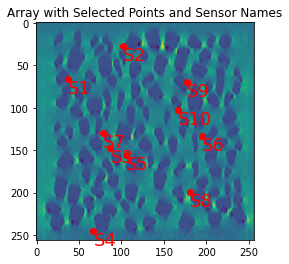

In [93]:
import matplotlib.pyplot as plt

sensor_names = ["S1", "S2", "S3", "S4", "S5", "S6", "S7", "S8", "S9", "S10"]

# Visualize the array and selected points
plt.imshow(output_data[0][0], interpolation='none')

# Plot selected points as red dots
plt.scatter(selected_indices[:, 1], selected_indices[:, 2], color='red', marker='o')

# Annotate each point with the corresponding sensor name
for i, name in enumerate(sensor_names):
    plt.text(selected_indices[i, 1], selected_indices[i, 2], name, color='red', fontsize=18, ha='left', va='top')

plt.title('Array with Selected Points and Sensor Names')
plt.show()


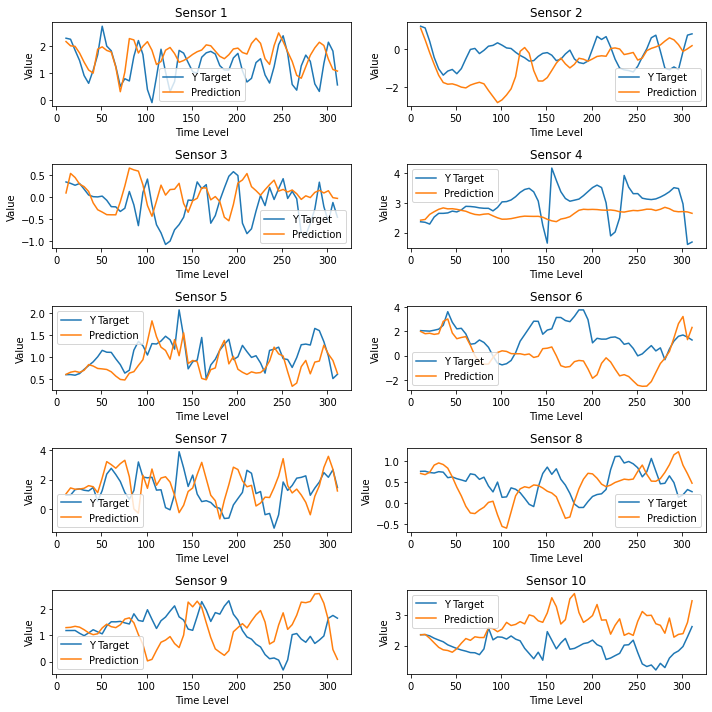

In [94]:
# Create a figure with 10 subplots
fig, axs = plt.subplots(5, 2, figsize=(10, 10))

# Iterate through the samples and create subplots
for i in range(10):
    # Select the i-th sample
    y_target_sample = numpy_array_Ytarget[:, i]
    prediction_sample = numpy_array_prediction[:, i]

    # Determine the subplot position
    row = i // 2
    col = i % 2
    # Plot Y target and prediction in the subplot
    axs[row, col].plot(numpy_array_timelevels, y_target_sample, label='Y Target')
    axs[row, col].plot(numpy_array_timelevels, prediction_sample, label='Prediction')
    axs[row, col].set_title(f'Sensor {i+1}')
    axs[row, col].set_xlabel('Time Level')
    axs[row, col].set_ylabel('Value')
    axs[row, col].legend()

# Adjust layout and show the figure
plt.tight_layout()
plt.show()

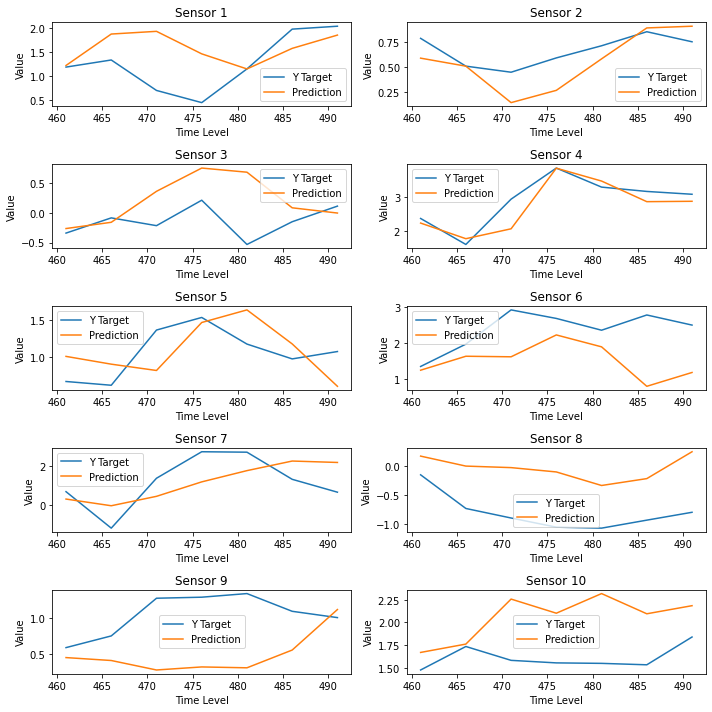

In [50]:
# Create a figure with 10 subplots
fig, axs = plt.subplots(5, 2, figsize=(10, 10))

# Iterate through the samples and create subplots
for i in range(10):
    # Select the i-th sample
    y_target_sample = numpy_array_Ytarget[:, i]
    prediction_sample = numpy_array_prediction[:, i]

    # Determine the subplot position
    row = i // 2
    col = i % 2
    # Plot Y target and prediction in the subplot
    axs[row, col].plot(numpy_array_timelevels, y_target_sample, label='Y Target')
    axs[row, col].plot(numpy_array_timelevels, prediction_sample, label='Prediction')
    axs[row, col].set_title(f'Sensor {i+1}')
    axs[row, col].set_xlabel('Time Level')
    axs[row, col].set_ylabel('Value')
    axs[row, col].legend()

# Adjust layout and show the figure
plt.tight_layout()
plt.show()

In [51]:
print(numpy_array_Ytarget.shape)
print(numpy_array_timelevels.shape)

(61, 10)
(61,)


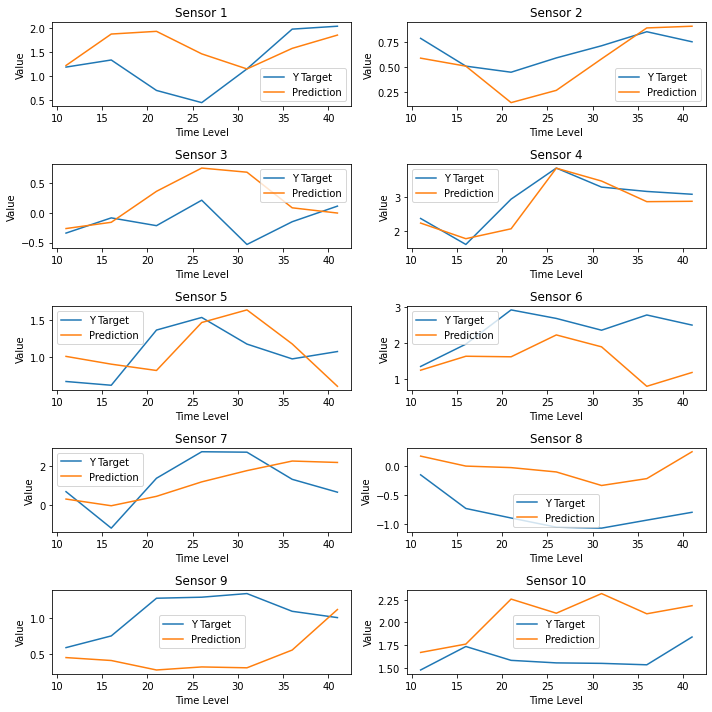

In [74]:
# Create a figure with 10 subplots
fig, axs = plt.subplots(5, 2, figsize=(10, 10))

# Iterate through the samples and create subplots
for i in range(10):
    # Select the i-th sample
    y_target_sample = numpy_array_Ytarget[:15, i]
    prediction_sample = numpy_array_prediction[:15, i]
    numpy_array_timelevels = numpy_array_timelevels[:15]

    # Determine the subplot position
    row = i // 2
    col = i % 2
    # Plot Y target and prediction in the subplot
    axs[row, col].plot(numpy_array_timelevels, y_target_sample, label='Y Target')
    axs[row, col].plot(numpy_array_timelevels, prediction_sample, label='Prediction')
    axs[row, col].set_title(f'Sensor {i+1}')
    axs[row, col].set_xlabel('Time Level')
    axs[row, col].set_ylabel('Value')
    axs[row, col].legend()

# Adjust layout and show the figure
plt.tight_layout()
plt.show()